# NFL draft comparison
- Want to be able to predict likelihood that a specific team/gm will want to draft a specific player
- Thinking of doing a model trained on the multiclass of team-gm with softmax for most likely team
- Feature I'm thinking of include age, team (or conference/power 4), athletic testing numbers, NGS scores, and consensus big board rank
- Also thinking of mapping GM tendencies on a PCA plot to see similarity in types of players

In [1]:
# Import packages and data
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, top_k_accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, balanced_accuracy_score,
    classification_report, log_loss, average_precision_score
)
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import ParameterGrid

# set seed for reproducibility
np.random.seed(123)

dev_level = 'dev'

In [2]:
# set path to data
path = 'C:/Users/sethl/OneDrive/Programming Stuff/USEFUL NFL FILES/'

def load_data(data_dir = 'data'):
    """Load all the football data"""
    data_files = os.listdir(data_dir)

    # Dictionary to store dataframes
    data = {}

    for file in data_files:
        file_path = os.path.join(data_dir, file)
        filename, ext = os.path.splitext(file)
        
        # Convert filename to a valid Python identifier
        var_name = filename.replace(" ", "_").replace("-", "_")
        
        if ext == '.csv':
            data[var_name] = pd.read_csv(file_path)
        elif ext == '.json':
            data[var_name] = pd.read_json(file_path)
        elif ext == '.txt':
            with open(file_path, 'r') as f:
                data[var_name] = f.read()

    for var_name, content in data.items():
        globals()[var_name] = content

if dev_level == 'dev':
    # Load the data if in development mode
    load_data(path)

    pff_conference_conversion = pd.read_excel('C:/Users/sethl/OneDrive/Excel Files/Football/Data Csv/PFF College conference addition.xlsx')

    gm_list = pd.read_excel("C:/Users/sethl/OneDrive/Excel Files/Football/Data Csv/Misc/NFL Coaching Changes 2011-2020.xlsm")
else:
    # In production mode, will load data in main function
    pass

# Data prep and feature engineering

In [9]:
working_df = College_PFF_player_mapping.copy()

working_df = (
    working_df
    .sort_values(by='score', ascending=False)
    .groupby('player_name', as_index=False)
    .head(1)
    .reset_index(drop=True)
)

working_df = pd.merge(working_df, College_NGS_Player_Scores, how = 'left', on = ['player_name', 'nic_year', 'pro_pos', 'school'])
working_df = pd.merge(working_df, Imputed_Big_Board_Ranks, how = 'left', on = ['player_name', 'nic_year', 'pro_pos', 'school'])
working_df = pd.merge(working_df, pff_conference_conversion, how = 'left', left_on = ['school'], right_on = ['pos_team'])

gm_list['label'] = gm_list['Team'] + '_' + gm_list['GM']

model_df = pd.merge(working_df, gm_list, how = 'left', left_on = ['draft_club', 'nic_year'], right_on = ['Team', 'season'])


model_df['draft_club'] = np.where((model_df['draft_club'].isna()) & (model_df['nic_year'] == 2025), 'current', model_df['draft_club'])

model_df = model_df[model_df['draft_club'].notna()]

model_df = model_df.drop_duplicates()
model_df = model_df.fillna(0)
model_df = model_df.reset_index(drop=True)

# Encode the position as a categorical variable

model_df = pd.get_dummies(model_df, columns=['nic_pos'], prefix='posi', drop_first=True)
model_df = pd.get_dummies(model_df, columns=['Strength'], prefix='conf', drop_first=True)

model_df = model_df.set_index('player_name')

test_model_df = model_df[model_df['draft_club'] == 'current']
train_model_df = model_df[model_df['draft_club'] != 'current']

train_model_df['label'] = train_model_df['label'].astype('category')
train_model_df['target'] = train_model_df['label'].cat.codes

full_model_df = model_df.copy()
full_model_df['label'] = full_model_df['label'].astype('category')
full_model_df['target'] = full_model_df['label'].cat.codes

C:\Users\sethl\AppData\Local\Temp\ipykernel_28516\1174281268.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  model_df = model_df.fillna(0)
C:\Users\sethl\AppData\Local\Temp\ipykernel_28516\1174281268.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_model_df['label'] = train_model_df['label'].astype('category')
C:\Users\sethl\AppData\Local\Temp\ipykernel_28516\1174281268.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [16]:
select_features = ['ht_in', 'wt', 'arm_in', 'wing_in',
                    'c_reps', 'c_10y', 'c_40y', 'c_vj_in', 'c_bj_in', 'c_3c', 'c_ss20', 'est_40y',
                      'underclassman', 'athleticism_score', 'production_score', 'final_score', 'imp_grade']

# select_features += [col for col in model_df.columns if col.startswith('posi_')]
select_features += [col for col in model_df.columns if col.startswith('conf_')]

def prepare_model_splits(model_df, select_features, alpha=0.5, ref_year=2021):
    """Create train/validation/test splits that respect time series nature, including sample weights"""     
    # Create X and y sets
    X = model_df[select_features]
    y = model_df['target']
    
    # Create sample weights
    sample_weights = np.exp(alpha * (model_df["nic_year"] - ref_year))
    
    # First, split into train+val and test
    X_temp, test_X, y_temp, test_y, sw_temp, test_sw = train_test_split(
        X, y, sample_weights, test_size=0.2, stratify=y, random_state=42
    )

    # Then, split train+val into actual train and validation
    train_X, X_val, train_y, y_val, train_sw, val_sw = train_test_split(
        X_temp, y_temp, sw_temp, test_size=0.25, stratify=y_temp, random_state=42
    )

    # Save the test indices
    test_indices = test_X.index
    
    return (X, y, train_X, train_y, train_sw,
            test_X, test_y, test_sw,
            X_val, y_val, val_sw,
            test_indices)


if dev_level == 'dev':

    (X, y, train_X, train_y, train_sw,
     test_X, test_y, test_sw,
     X_val, y_val, val_sw,
     test_indices) = prepare_model_splits(train_model_df, select_features)

    prediction_set = test_model_df[select_features]

    full_predictions = full_model_df[select_features]
    
else:
    pass

In [23]:

def evaluate_multiclass_model(test_X=None, test_y=None, test_sw = None, model=None, y_proba=None, class_labels=None, top_k=(1, 5), plot_confusion=True):
    """
    Evaluate a multiclass classifier with probabilistic metrics.
    
    Parameters:
    - test_X: Features (optional if y_proba is given)
    - test_y: True labels
    - model: Trained classifier (must support predict_proba)
    - y_proba: Optional — predicted probabilities (n_samples, n_classes)
    - class_labels: Optional — list of class names
    - top_k: Tuple of k-values for top-k accuracy
    - plot_confusion: Whether to show the confusion matrix

    Returns:
    - Dictionary of evaluation metrics
    """
    
    if y_proba is None:
        if model is None or test_X is None:
            raise ValueError("Either a model and test_X, or y_proba must be provided.")
        y_proba = model.predict_proba(test_X)
    
    y_pred = np.argmax(y_proba, axis=1)

    results = {}

    # Log loss
    results['log_loss'] = log_loss(test_y, y_proba, sample_weight=test_sw) if test_sw is not None else log_loss(test_y, y_proba)

    # ROC-AUC
    try:
        results['roc_auc_ovr_macro'] = roc_auc_score(test_y, y_proba, multi_class='ovr', average='macro', sample_weight=test_sw) if test_sw is not None else roc_auc_score(test_y, y_proba, multi_class='ovr', average='macro')
    except Exception as e:
        results['roc_auc_ovr_macro'] = f"Unavailable: {e}"

    # Top-K accuracy
    for k in top_k:
        try:
            score = top_k_accuracy_score(test_y, y_proba, k=k, sample_weight=test_sw) if test_sw is not None else top_k_accuracy_score(test_y, y_proba, k=k)
            results[f'top_{k}_accuracy'] = score
        except Exception as e:
            results[f'top_{k}_accuracy'] = f"Unavailable: {e}"

    # Print results
    print("Evaluation Metrics:")
    for k, v in results.items():
        print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(test_y, y_pred, target_names=class_labels if class_labels else None))

    # Confusion matrix
    if plot_confusion:
        cm = confusion_matrix(test_y, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_labels if class_labels else 'auto',
                    yticklabels=class_labels if class_labels else 'auto')
        plt.title("Confusion Matrix")
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.tight_layout()
        plt.show()

    return y_proba, y_pred, results

Starting grid search for XGBoost (Multiclass)...
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best macro PR-AUC: 0.0318
Evaluation Metrics:
log_loss: 4.2819
roc_auc_ovr_macro: 0.3894
top_1_accuracy: 0.0279
top_5_accuracy: 0.1540

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00        15
           7       0.02      0.20      0.04        10
           8       0.00      0.00      0.00        24
           9       0.02      0.09      0.04        11
          10       0.00      0.00      0.00         3
          11     

c:\Users\sethl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sethl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sethl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

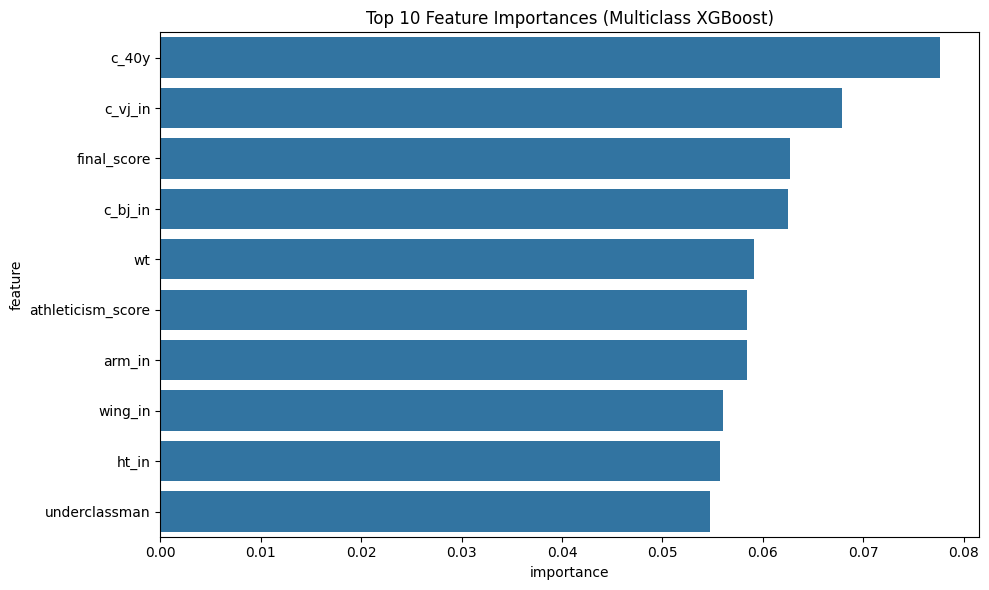

In [24]:
# Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

def xgboost_model(train_X, train_y, test_X, test_y, X_val, y_val, val_sw, train_sw, test_sw):
    """Build and evaluate a multiclass XGBoost model with hyperparameter tuning"""
    
    # Get number of classes
    num_classes = len(np.unique(train_y))
    
    # Define the parameter grid
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    
    best_pr_auc = -np.inf
    best_grid = None
    best_model = None
    
    print("Starting grid search for XGBoost (Multiclass)...")
    for g in ParameterGrid(param_grid):
        model = xgb.XGBClassifier(
            **g,
            objective='multi:softprob',
            num_class=num_classes,
            eval_metric='mlogloss',
            early_stopping_rounds=10
        )

        model.fit(
            train_X, train_y,
            eval_set=[(X_val, y_val)],
            verbose=False,
            sample_weight_eval_set=[val_sw],
        )
        
        # Predict probabilities
        y_proba = model.predict_proba(test_X)
        
        # Convert test_y to binary matrix for PR-AUC
        y_test_bin = label_binarize(test_y, classes=np.arange(num_classes))
        
        # Compute macro-average PR-AUC
        try:
            pr_auc_val = average_precision_score(y_test_bin, y_proba, average="macro")
        except ValueError:
            pr_auc_val = 0  # If class missing in binarized labels

        if pr_auc_val > best_pr_auc:
            best_pr_auc = pr_auc_val
            best_grid = g
            best_model = model

    print("Best Hyperparameters:", best_grid)
    print(f"Best macro PR-AUC: {best_pr_auc:.4f}")
    
    # Retrain on full train set with best params
    best_model = xgb.XGBClassifier(
        **best_grid,
        objective='multi:softprob',
        num_class=num_classes
    )
    best_model.fit(train_X, train_y, verbose=False,
            sample_weight=train_sw)
    
    # Final evaluation
    y_proba, y_pred, results = evaluate_multiclass_model(
        test_X, test_y, test_sw=test_sw,
        model=best_model, 
        plot_confusion=False
    )

    # Feature importances
    feature_importances = pd.DataFrame({
        'feature': train_X.columns,
        'importance': best_model.feature_importances_
    })
    
    top_features = feature_importances.sort_values(by='importance', ascending=False).head(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_features, x='importance', y='feature')
    plt.title("Top 10 Feature Importances (Multiclass XGBoost)")
    plt.tight_layout()
    plt.show()
    
    return best_model, y_proba, y_pred, results


if dev_level == 'dev':

    best_model, y_proba, y_pred, results = xgboost_model(train_X, train_y, test_X, test_y, X_val, y_val, val_sw, train_sw, test_sw)
    
else:
    pass

# Make predictions

In [25]:
# Make predictions on the prediction set
y_proba = best_model.predict_proba(prediction_set)

# Filter to only the most recent GMs to make draft picks
filter_indices = train_model_df[train_model_df['season'] == 2024]['target'].drop_duplicates().reset_index(drop=True).to_list()

# Step 1: Create a mask for columns that do not match filter_indices
all_indices = np.arange(y_proba.shape[1])  # All column indices of y_proba
columns_to_zero = np.setdiff1d(all_indices, filter_indices)  # Columns that are not in filter_indices

# Step 2: Set the values of the non-matching columns to 0
y_proba[:, columns_to_zero] = 0

# Get the most likely gm for each player
y_pred = np.argmax(y_proba, axis=1)

# Decode the predicted labels
# Convert the predicted labels back to their original categorical values
categories = train_model_df['label'].cat.categories
y_pred_decoded = categories[y_pred]
y_pred_decoded = pd.Series(y_pred_decoded, index=prediction_set.index)

# Create a new DataFrame with the predicted labels and the original columns
updated_prediction_set = prediction_set.copy()
updated_prediction_set['predicted_label'] = y_pred_decoded
updated_prediction_set = updated_prediction_set[['predicted_label'] + [col for col in updated_prediction_set.columns if col != 'predicted_label']]

In [60]:
# Make predictions on the prediction set
y_proba = best_model.predict_proba(full_predictions)

# Filter to only the most recent GMs to make draft picks
filter_indices = train_model_df[train_model_df['season'] == 2024]['target'].drop_duplicates().reset_index(drop=True).to_list()

# Step 1: Create a mask for columns that do not match filter_indices
all_indices = np.arange(y_proba.shape[1])  # All column indices of y_proba
columns_to_zero = np.setdiff1d(all_indices, filter_indices)  # Columns that are not in filter_indices

# Step 2: Set the values of the non-matching columns to 0
y_proba[:, columns_to_zero] = 0

# Get the most likely gm for each player
y_pred = np.argmax(y_proba, axis=1)

# Decode the predicted labels
# Convert the predicted labels back to their original categorical values
categories = train_model_df['label'].cat.categories
y_pred_decoded = categories[y_pred]
y_pred_decoded = pd.Series(y_pred_decoded, index=full_predictions.index)

# Create a new DataFrame with the predicted labels and the original columns
updated_full_predictions = full_predictions.copy()
updated_full_predictions['predicted_label'] = y_pred_decoded
updated_full_predictions = updated_full_predictions[['predicted_label'] + [col for col in updated_full_predictions.columns if col != 'predicted_label']]

# Similarity Plot

c:\Users\sethl\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
c:\Users\sethl\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))
c:\Users\sethl\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
c:\Users\sethl\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\text.py:763: FutureWarning: Calling float on a single element Series is d

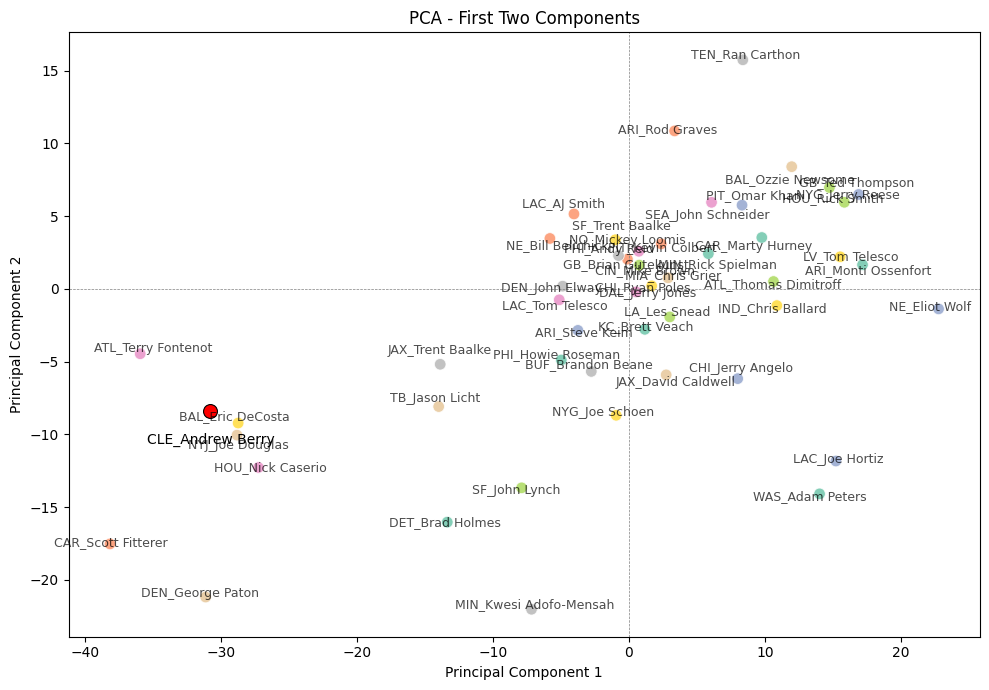

In [27]:
from sklearn.decomposition import PCA

tenured_gms = model_df.copy()
# Count picks per GM
gm_pick_counts = tenured_gms.groupby('label')['school'].count()

# GMs with more than 35 picks
gms_with_35_plus_picks = gm_pick_counts[gm_pick_counts > 50].index

# GMs who made picks in 2024
gms_in_2024 = tenured_gms[tenured_gms['season'] == 2024]['label'].unique()

# Union of both sets
tenured_gms_list = list(set(gms_with_35_plus_picks).union(set(gms_in_2024)))


pca_df = train_model_df.copy()
pca_df = pca_df[pca_df['label'].isin(tenured_gms_list)]

X = pca_df[select_features]
y = pca_df['target']

# Step 1: Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 1: Fit PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)  # X should be your feature matrix (numeric only)


# Explained variance for each component
explained_variance = pca.explained_variance_ratio_

# Total variance explained by the two components
total_explained_variance = explained_variance.sum()

# Step 2: Create a DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['label'] = y.values  # y = your labels (can be integers or categories)

# Optional: if y is encoded, decode it
pca_df['label'] = categories[y]

# Group by label and calculate mean for each PC
pca_means = pca_df.groupby('label').mean().reset_index()    

selected = pca_means[pca_means['label'] == 'CLE_Andrew Berry']

pca_means = pca_means[pca_means['label'] != 'CLE_Andrew Berry']


plt.figure(figsize=(10, 7))

# Create scatterplot
sns.scatterplot(data=pca_means, x='PC1', y='PC2', hue='label', palette='Set2', s=70, alpha=0.8)

# Add jittered text annotations for each point
for i in range(pca_means.shape[0]):
    jitter_x = np.random.uniform(-1, 1)  # Jitter in x direction
    jitter_y = np.random.uniform(-1, 1)  # Jitter in y direction
    
    plt.text(pca_means['PC1'].iloc[i] + jitter_x, 
             pca_means['PC2'].iloc[i] + jitter_y, 
             pca_means['label'].iloc[i], 
             fontsize=9, alpha=0.7, color='black', ha='center', va='center')

# Title and labels
plt.title("PCA - First Two Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Put dashed lines at every 5 units for both axes
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)


sns.scatterplot(data=selected, x='PC1', y='PC2', s=100, color = 'red', edgecolor = 'black')
plt.text(selected['PC1'], 
            selected['PC2'] - 2, 
            selected['label'].values[0],
            fontsize=10, alpha=1, color='black', ha='center', va='center')


# Remove the legend
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left').set_visible(False)

# Tight layout to ensure everything fits
plt.tight_layout()

# Show the plot
plt.show()

# Deep dives into the GMs

In [78]:
# Get the average of each column for each GM
averages = train_model_df[select_features + ['label']].groupby('label').mean().reset_index()


context_columns = model_df[['nic_year', 'pro_pos', 'school', 'label']]


y_proba_decoded = pd.DataFrame(y_proba, index=full_predictions.index)

y_proba_decoded.columns = categories  # Set the column names to the original labels
# Filter out the columns that have all zeros
# y_proba_decoded = y_proba_decoded.loc[:, (y_proba_decoded != 0).any(axis=0)]

current_top5 = np.argsort(y_proba_decoded.values, axis=1)[:, -5:]  # Get indices of top 5 predicted labels for each player
top5_probs = np.take_along_axis(y_proba_decoded.values, current_top5, axis=1)

n_top = 5

data = pd.DataFrame(index=y_proba_decoded.index)
for i in range(n_top):
    data[f'top{i+1}_class'] = current_top5[:, -(i+1)]
    data[f'top{i+1}_prob'] = top5_probs[:, -(i+1)]

top5_df = pd.DataFrame(data)

# Convert the indices to actual labels
class_cols = [col for col in top5_df.columns if "class" in col]

for col in class_cols:
    top5_df[col] = top5_df[col].apply(lambda x: categories[x])

    

top5_df = pd.merge(top5_df, context_columns, how = 'left', left_index=True, right_index=True)

current_year = top5_df[top5_df['nic_year'] == 2025].copy()
current_year = current_year[['nic_year', 'pro_pos', 'school'] + [col for col in current_year.columns if col not in ['nic_year', 'pro_pos', 'school']]]
current_year = current_year.drop(columns = ['label'])


top5_df = top5_df.rename(columns={'label': 'Actual_GM'})
top5_df['Correct'] = np.where(top5_df['Actual_GM'] == top5_df['top1_class'], 1, 0)

top5_df = top5_df[['nic_year', 'pro_pos', 'school', 'Actual_GM', 'Correct'] + [col for col in top5_df.columns if col not in ['nic_year', 'pro_pos', 'school', 'Actual_GM', 'Correct']]]


all_players_top5 = pd.DataFrame()

for gm in train_model_df['label'].unique():
    # Check if the GM is in the top 5 labels for each player
    gm_mask = top5_df.isin([gm])  # Create a mask for the GM
    gm_players = full_predictions[gm_mask.any(axis=1)]  # Get players for this GM
    gm_players['GM'] = gm  # Add GM label to the DataFrame

    all_players_top5 = pd.concat([all_players_top5, gm_players], axis=0)

all_players_top5 = all_players_top5[['GM'] + [col for col in all_players_top5.columns if col != 'GM']]

all_players_top5 = pd.merge(all_players_top5, context_columns, how = 'left', left_index=True, right_index=True)


all_players_top5 = all_players_top5[['nic_year', 'pro_pos', 'school'] + [col for col in all_players_top5.columns if col not in ['nic_year', 'pro_pos', 'school']]]

all_players_top5 = all_players_top5[['nic_year', 'pro_pos', 'school', 'GM']]


top5_df = top5_df[top5_df['nic_year'] != 2025]


C:\Users\sethl\AppData\Local\Temp\ipykernel_28516\22501897.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  averages = train_model_df[select_features + ['label']].groupby('label').mean().reset_index()
C:\Users\sethl\AppData\Local\Temp\ipykernel_28516\22501897.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gm_players['GM'] = gm  # Add GM label to the DataFrame
C:\Users\sethl\AppData\Local\Temp\ipykernel_28516\22501897.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

Want to make a streamlit app that displays this information
- Table of upcoming draft picks by their top 5 GMS
- Select a GM and see their spot on the similarity plot specifically highlighted
- See the table for the GM averages
- See the table for the top 5 players for a GM
- See the table for all the players that were in a GMs top 5

Sort the tables first, then save them
Create the current prospects and then sort by highest first predictions first before concatenating and saving

In [80]:
all_players_top5 = all_players_top5.sort_values(by = ['player_name'], ascending=[True])
top5_df = top5_df.sort_values(by = ['top1_prob'], ascending=[False])
current_year = current_year.sort_values(by = ['top1_prob'], ascending=[False])


In [81]:
top5_df.to_csv('streamlit_app/top_5_labels.csv', index=True)
current_year.to_csv('streamlit_app/current_year.csv', index=True)
averages.to_csv('streamlit_app/averages.csv', index=True)
all_players_top5.to_csv('streamlit_app/all_players_top5.csv', index=True)